In [1]:
#Backbone net

import torch
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
import HAWaNet

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [2]:
state_dict = load_state_dict_from_url(model_urls['resnet50'])

In [3]:
import torch.nn as nn
import torchvision.models
import tqdm
import matplotlib.pyplot as plt

def convrelu(in_channels, out_channels, kernel, padding):
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
      )



class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__(block = BasicBlock, layers = [2,2,2,2])

        #self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_model = ResNet(block = BasicBlock, layers = [2,2,2,2])
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
    
    def forward(self, image, depth):
        x_original = self.conv_original_size0(image)
        #print(type(image))
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(image)
        #print(layer0.shape)
        layer1 = self.layer1(layer0)
        print(layer1.shape)
        layer2 = self.layer2(torch.add(layer1,depth))
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)
        
        return out
    
    

In [4]:
import torch.nn as nn
import torchvision.models
import tqdm
import matplotlib.pyplot as plt

def convrelu(in_channels, out_channels, kernel, padding):
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
      )



class ResNetUNet_updated(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet50(pretrained=True)
        self.channel_adjust = nn.Conv2d(1, 3, 3, padding=1)
        self.attention = HAWaNet()
        #self.base_model = ResNet(block = BasicBlock, layers = [2,2,2,2])
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(512, 512, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(3072, 1536, 3, 1)
        self.conv_up2 = convrelu(2048, 1024, 3, 1)
        self.conv_up1 = convrelu(1280, 512, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)

        #self.conv_last = nn.Conv2d(64, n_class, 1)
        self.conv_last = nn.Conv2d(512, n_class, 1)
        self.conv_depth = nn.Conv2d(1,64,3,1)
        
    
    def forward(self, image, depth):
        
        #print(image.shape)
        image = self.channel_adjust(image)
        #print(image.shape)
        x_original = self.conv_original_size0(image)
        #print(type(image))
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(image)
        #print(layer0.shape)
        layer1 = self.layer1(layer0)
        layer1_a = self.attention(layer1)
        #print(layer1.shape)
        
        layer2 = self.layer2(torch.add(layer1_a,depth))
        #layer_depth = self.conv_depth(depth)
        #print(depth.shape)
        #layer2 = self.layer2(layer1)
        #add the depth here!
        #layer_depth = self.conv_depth(depth)
        
        
        
        layer3 = self.layer3(layer2)
        layer3_a = self.attention(layer3)
        layer4 = self.layer4(layer3_a)
        #print(layer4.shape)
        layer4 = self.layer4_1x1(layer4)
        #print(layer4.shape)
        x = self.upsample(layer4)
        #print(x.shape)
        layer3 = self.layer3_1x1(layer3)
        #print(layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        #print(x.shape)
        x = self.conv_up3(x)
        #print(x.shape)
        x = self.upsample(x)
        #print(x.shape)
        layer2 = self.layer2_1x1(layer2)
        #print(layer2.shape)
        x = torch.cat([x, layer2], dim=1)
        #print('here', x.shape)
        x = self.conv_up2(x)
        #print('here1', x.shape)
        x = self.upsample(x)
        #print('here2', x.shape)
        layer1 = self.layer1_1x1(layer1)
        #print('here3', layer1.shape)
        x = torch.cat([x, layer1], dim=1)
        #print('here4', x.shape)
        x = self.conv_up1(x)
        #print('here 5 ', x.shape)
        x = self.upsample(x)
        #print('here 6 ', x.shape)
        '''
        layer0 = self.layer0_1x1(layer0)
        print('here 1 ', layer0.shape)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        #x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        '''
        out = self.conv_last(x)
        
        return out

In [5]:
model = ResNetUNet_updated(n_class=19)
#model.double()
#model.cuda()
#model(torch.randn(1,1,512,1408).float(),torch.randn(1,1,128,352)).shape


torch.Size([1, 19, 256, 704])

In [11]:
nn.Conv2d(1, 64, 3, padding=1)(torch.randn(1,1,128,384)).shape

torch.Size([1, 64, 128, 384])

In [6]:
from torchsummary import summary
summary(ResNetUNet_updated(n_class=9))

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              75,008
|    |    └─Bottleneck: 3-2              70,400
|    |    └─Bottleneck: 3-3              70,400
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              379,392
|    |    └─Bottleneck: 3-5              280,064
|    |    └─Bottleneck: 3-6              280,064
|    |    └─Bottleneck: 3-7              280,064
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              1,512,448
|    |    └─Bottleneck: 3-9              1,117,184
|    |    └─Bottleneck: 3-10             1,117,184
|    |    └─Bottleneck: 3-11             1,117,184
|    |    └─Bottleneck: 3-12             1,117,184


Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       9,408
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              75,008
|    |    └─Bottleneck: 3-2              70,400
|    |    └─Bottleneck: 3-3              70,400
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              379,392
|    |    └─Bottleneck: 3-5              280,064
|    |    └─Bottleneck: 3-6              280,064
|    |    └─Bottleneck: 3-7              280,064
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              1,512,448
|    |    └─Bottleneck: 3-9              1,117,184
|    |    └─Bottleneck: 3-10             1,117,184
|    |    └─Bottleneck: 3-11             1,117,184
|    |    └─Bottleneck: 3-12             1,117,184


In [5]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import cv2
import torch
import numpy as np
import PIL.Image
import cv2


class SignalImages(Dataset):
    def __init__(self, segmentation_mask_dir, img_dir):
        self.segmentation_mask_dir = sorted(segmentation_mask_dir)
        self.img_dir = sorted(img_dir)
        #self.transform = transform
        #self.target_transform = target_transform
        
        

    def __len__(self):
        return len(self.img_dir)
    
    def normalize_signal_image(self,signal):
        min_val = 0
        max_val = 80000
        signal[np.isnan(signal)]=0.00001
        
        #print(signal)
        
        signal[signal>max_val] = 0
        signal[signal<min_val] = 0
        norm = (signal-min_val)/(max_val-min_val)
        
        return norm
    
    def normalize_visual_image(self,signal):
        min_val = 0
        max_val = 255
        signal[np.isnan(signal)]=0.00001
        
        #print(signal)
        
        signal[signal>max_val] = 0
        signal[signal<min_val] = 0
        norm = (signal-min_val)/(max_val-min_val)
        
        return norm
    
    def make_it_3D(self,image):
        '''
        l1 = 10000
        l2 = 20000
        image[np.isnan(image)]= 0.00001
        b = np.zeros((3,512,1536))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                #print(a[i,j])
                val = image[i,j]
                if val<=l1:
                    b[0,i,j] = val
                elif val>l1 and val<=l2:
                    b[1,i,j] = val
                else:
                    b[2,i,j] = val
        b[0,:,:] = (b[0,:,:]-b[0,:,:].min())/(b[0,:,:].max()-b[0,:,:].min())
        b[1,:,:] = (b[1,:,:]-b[1,:,:].min())/(b[1,:,:].max()-b[1,:,:].min())
        b[2,:,:] = (b[2,:,:]-b[2,:,:].min())/(b[2,:,:].max()-b[2,:,:].min())
        '''
        image[np.isnan(image)]= 0.00001
        return (image/85000)
    
    def read_bin_files(self,file_name):
        
        data = np.fromfile(file_name, dtype='<d')
        nr_rows = 512
        nr_cols = int(len(data)/nr_rows)
        return data.reshape((nr_rows,nr_cols))
    
    def __getitem__(self, idx):
        
        
        if self.img_dir[idx].endswith('.bin'):
            
            image = self.make_it_3D(self.read_bin_files(self.img_dir[idx]))
            #print(type(image))
            #inter = np.zeros((3,512,1536))
            #inter[:2,:,:] = image
        '''
        
        if self.img_dir[idx].endswith('.bin'):
            
            image = self.normalize_signal_image(self.read_bin_files(self.img_dir[idx]))
            #print(type(image))
            inter = np.zeros((3,512,1536))
            inter[:2,:,:] = image
        
        '''
        if self.img_dir[idx].endswith('.png'):
            inter = self.normalize_visual_image(read_image(self.img_dir[idx]))
            inter = image.repeat(3, 1, 1)
            
        if self.segmentation_mask_dir[idx].endswith('.bin'):
            label = self.normalize_signal_image(self.read_bin_files(self.segmentation_mask_dir[idx]))
            
            
        if self.segmentation_mask_dir[idx].endswith('.png'):
            label = torch.tensor(np.asarray(PIL.Image.open(self.segmentation_mask_dir[idx])))
            
        #label = read_image(segmentation_mask_dir[idx])
        
        return {"image":torch.tensor(image)[:,:,128:], "label":label[:,128:], "name": self.img_dir[idx]}

In [6]:
import XenoWareFormat as xw

class SignalImages_Depth(Dataset):
    def __init__(self, segmentation_mask_dir, img_dir, depth_dir):
        self.segmentation_mask_dir = sorted(segmentation_mask_dir)
        self.img_dir = sorted(img_dir)
        self.depth_dir = sorted(depth_dir)
        #self.transform = transform
        #self.target_transform = target_transform
        
    def choose_classes(self,label):
        useful_labels = [0, 13, 14, 15, 17, 18]
        new_label = np.ones((label.shape[0], label.shape[1]))
        
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i,j] in useful_labels:
                    new_label[i,j] = useful_labels.index(label[i,j])
                else:
                    new_label[i,j] = 7
        return new_label

    def __len__(self):
        return len(self.img_dir)
    
    def normalize_signal_image(self,signal):
        min_val = 0
        max_val = 80000
        signal[np.isnan(signal)]=0.00001
        
        #print(signal)
        
        signal[signal>max_val] = 0
        signal[signal<min_val] = 0
        norm = (signal-min_val)/(max_val-min_val)
        
        return norm
    
    def normalize_visual_image(self,signal):
        min_val = 0
        max_val = 255
        signal[np.isnan(signal)]=0.00001
        
        #print(signal)
        
        signal[signal>max_val] = 0
        signal[signal<min_val] = 0
        norm = (signal-min_val)/(max_val-min_val)
        
        return norm
    
    def make_it_3D(self,image):
        
        '''
        l1 = 10000
        l2 = 20000
        image[np.isnan(image)]= 0.00001
        b = np.zeros((3,512,1536))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                #print(a[i,j])
                val = image[i,j]
                if val<=l1:
                    b[0,i,j] = val
                elif val>l1 and val<=l2:
                    b[1,i,j] = val
                else:
                    b[2,i,j] = val
        b[0,:,:] = (b[0,:,:]-b[0,:,:].min())/(b[0,:,:].max()-b[0,:,:].min())
        b[1,:,:] = (b[1,:,:]-b[1,:,:].min())/(b[1,:,:].max()-b[1,:,:].min())
        b[2,:,:] = (b[2,:,:]-b[2,:,:].min())/(b[2,:,:].max()-b[2,:,:].min())
        '''
        b = np.zeros((1,512,1536))
        image[np.isnan(image)]= 0.00001
        b[0,:,:] = (image/85000)
        return b
        
    
    def read_transform_depth(self, file_name):
        
        [c2,m2] = xw.XW_ReadFile(file_name)
        
        new_mapping = np.zeros((128,384))
        
        for i in range(c2['data'].shape[0]):
            u1 = int((128*c2['data'][i][4])/512)-1
            v1 = int((384*c2['data'][i][5])/1536)-1
            #print(u1,v1)
            new_mapping[v1,u1] = c2['data'][i][6]
        new_mapping[np.isnan(new_mapping)]= 0.00001
        return new_mapping/200000
    
    def read_bin_files(self,file_name):
        
        data = np.fromfile(file_name, dtype='<d')
        nr_rows = 512
        nr_cols = int(len(data)/nr_rows)
        return data.reshape((nr_rows,nr_cols))
    
    def __getitem__(self, idx):
        
        
        if self.img_dir[idx].endswith('.bin'):
            
            image = self.make_it_3D(self.read_bin_files(self.img_dir[idx]))
            #print(type(image))
            #inter = np.zeros((3,512,1536))
            #inter[:2,:,:] = image
            
        if self.img_dir[idx].endswith('.xsg'):
            
            [c2,m2] = xw.XW_ReadFile(self.img_dir[idx])
            
            image = self.make_it_3D(c2['data'])
            
            #print(type(image))
            #inter = np.zeros((3,512,1536))
            #inter[:2,:,:] = image
        '''
        
        if self.img_dir[idx].endswith('.bin'):
            
            image = self.normalize_signal_image(self.read_bin_files(self.img_dir[idx]))
            #print(type(image))
            inter = np.zeros((3,512,1536))
            inter[:2,:,:] = image
        
        '''
        if self.img_dir[idx].endswith('.png'):
            inter = self.normalize_visual_image(read_image(self.img_dir[idx]))
            inter = image.repeat(3, 1, 1)
        '''    
        if self.segmentation_mask_dir[idx].endswith('.bin'):
            label = self.normalize_signal_image(self.read_bin_files(self.segmentation_mask_dir[idx]))
        '''    
            
        if self.segmentation_mask_dir[idx].endswith('.png'):
            label = PIL.Image.open(self.segmentation_mask_dir[idx])
            label = np.asarray(label)
            label = cv2.resize(label, (768,256), interpolation = cv2.INTER_NEAREST)
            label = torch.tensor(label,dtype=torch.int32)
            #label = torch.tensor(np.asarray(PIL.Image.open(self.segmentation_mask_dir[idx])), dtype=torch.int32)
            #label1 = self.choose_classes(label)
        depth = self.read_transform_depth(self.depth_dir[idx])
        #print(self.depth_dir[idx])
        #print(self.img_dir[idx])
        #print(self.segmentation_mask_dir[idx])
        #label = read_image(segmentation_mask_dir[idx])
        
        return {"image":torch.tensor(image)[:,:,256:1280], "label":label[:,128:640],"depth":depth[:,64:320], "name": self.img_dir[idx]}

In [32]:
#Signal Images
train_images_dir = "/home/adarsh/Documents/Dataset/xenolidar/train_signal_images1"
test_images_dir = "/home/adarsh/Documents/Dataset/xenolidar/test_signal_images"

train_images = [train_images_dir+'/'+i for i in os.listdir(train_images_dir)]
test_images = [test_images_dir+'/'+i for i in os.listdir(test_images_dir)]

train_mask_dir = "/home/adarsh/Documents/Dataset/xenolidar/train_annot_masks1"
test_mask_dir = "/home/adarsh/Documents/Dataset/xenolidar/test_annot_masks1"

train_masks = [train_mask_dir + '/' + i for i in os.listdir(train_mask_dir)]
test_masks = [test_mask_dir + '/' + i for i in os.listdir(test_mask_dir)]

train_depth_dir = "/home/adarsh/Documents/Dataset/xenolidar/train_depth1"
test_depth_dir = "/home/adarsh/Documents/Dataset/xenolidar/test_depth"

train_depth = [train_depth_dir+'/'+i for i in os.listdir(train_depth_dir)]
test_depth = [test_depth_dir+'/'+i for i in os.listdir(test_depth_dir)]

train_data = SignalImages_Depth(segmentation_mask_dir =train_masks , img_dir =train_images, depth_dir = train_depth )
test_data = SignalImages_Depth(segmentation_mask_dir =test_masks , img_dir =test_images, depth_dir = test_depth )




In [7]:
#Signal Images New Data

train_mask_dir = "/home/adarsh/Documents/Dataset/Dataset_10k/all/AI_Data/Sem_New"
test_mask_dir = "/home/adarsh/Documents/Dataset/testdataset_01/AI_Data/Sem_New"

train_masks = [train_mask_dir + '/' + i for i in sorted(os.listdir(train_mask_dir))[1:]]
test_masks = [test_mask_dir + '/' + i for i in os.listdir(test_mask_dir)]

train_images_dir = "/home/adarsh/Documents/Dataset/Dataset_10k/all/AI_Data/SignalImages"
test_images_dir = "/home/adarsh/Documents/Dataset/testdataset_01/AI_Data/SignalImages"

train_images = [train_images_dir+'/'+i.replace('_label.png','.xsg').replace('xl_visual','xl_signal') for i in sorted(os.listdir(train_mask_dir))[1:]]
test_images = [test_images_dir+'/'+i.replace('_label.png','.xsg').replace('xl_visual','xl_signal') for i in sorted(os.listdir(test_mask_dir))]


train_depth_dir = "/home/adarsh/Documents/Dataset/Dataset_10k/all/AI_Data/XPC"
test_depth_dir = "/home/adarsh/Documents/Dataset/testdataset_01/AI_Data/XPC"

train_depth = [train_depth_dir+'/'+'xw_pointcloud'+i.replace('_label.png','.xpc').replace('xl_visual','') for i in sorted(os.listdir(train_mask_dir))[1:]]
test_depth = [test_depth_dir+'/'+'xw_pointcloud'+i.replace('_label.png','.xpc').replace('xl_visual','') for i in sorted(os.listdir(test_mask_dir))]

train_data = SignalImages_Depth(segmentation_mask_dir =train_masks , img_dir =train_images, depth_dir = train_depth )
test_data = SignalImages_Depth(segmentation_mask_dir =test_masks , img_dir =test_images, depth_dir = test_depth )


In [8]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

NameError: name 'DataLoader' is not defined

In [9]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)


NameError: name 'DataLoader' is not defined

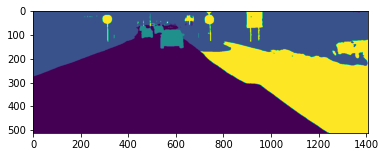

In [35]:
plt.imshow(train_data[0]['label'])

In [42]:
train_data[0]['label'].shape

torch.Size([256, 640])

In [10]:
from torch.utils.data import DataLoader
import torch
device = torch.device('cuda')
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

model = ResNetUNet_updated(n_class = 9)
model = torch.load('test_3channel_fusion_t102429.pth')

model = model.to(device)


NameError: name 'model' is not defined

In [9]:
model.double()

ResNetUNet_updated(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [11]:
import torch.nn.functional as F

def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)



def dice_similarity(prediction, labels):
    
    num_labels= prediction.shape[1]
    if len(prediction.shape)==3:
        num_labels= 19
        prediction = torch.eye(num_labels)[prediction.long().squeeze(1)]
        prediction = prediction.permute(0, 3, 1, 2).float()
        #print(prediction.shape)
    true_1_hot = torch.eye(num_labels)[labels.long().squeeze(1)]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    dice_coeff = 0
    for i in range(num_labels):
        dice_coeff +=dice_coef(true_1_hot[:,i,:,:],prediction[:,i,:,:])
        #print(dice_coef(true_1_hot[:,i,:,:],prediction[:,i,:,:]))
    return (dice_coeff/num_labels).item()
    
def dice_coef(y_true, y_pred):
    
    y_true_ft = torch.flatten(y_true).cpu()
    y_pred_ft = torch.flatten(y_pred).cpu()
    intersection_t = torch.sum(y_true_ft * y_pred_ft)
    smooth = 0.0001
    return (2. * intersection_t + smooth) / (torch.sum(y_true_ft) + torch.sum(y_pred_ft) + smooth)

In [ ]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

#model = model.to(device)



for epoch in range(30):  # loop over the dataset multiple times
    model.train()
    
    print(epoch)
    running_loss = 0.0
    dice_coeff = 0
    for i, data in tqdm.tqdm(enumerate(train_dataloader, 0)):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs= data ["image"].to(device)
            
        labels = data ["label"].to(device)
        depth = data["depth"].to(device)
        #labels = torch.argmax(labels,dim=1)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        #k = torch.rand(1,3,512,1536)
        #outputs = model(inputs.float())
        outputs = model(inputs.float(),depth.float())
        
        multiplier = 0.5
        #loss = multiplier*criterion(outputs.float(), labels.long())+ (1-multiplier)* dice_loss(labels.long(),outputs.float())
        loss = criterion(outputs.float(), labels.long())
        dice_coeff += dice_similarity(outputs, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    '''        
    if (epoch+1)%5==0:
        dice_coeff_test = 0
        for i, data in tqdm.tqdm(enumerate(test_dataloader, 0)):
            
            inputs= data ["image"].to(device) 
            labels = data ["label"].to(device)
            depth = data["depth"].to(device)
            model.eval()
            outputs = model(inputs.float(),depth.float())
            dice_coeff_test += dice_similarity(outputs, labels)
            
        print('Test dice coefficient ', dice_coeff_test/len(test_dataloader))
    '''        
    torch.save(model,'test_3channel_fusion_t1024'+str(epoch)+'.pth')
    print(running_loss)
    print('dice similarity train' , dice_coeff/len(train_dataloader))
        
        
print('Finished Training')

In [11]:
dice_coeff_test = 0
model.eval()
for i, data in tqdm.tqdm(enumerate(test_dataloader, 0)):

    inputs= data ["image"].to(device) 
    labels = data ["label"].to(device)
    depth = data["depth"].to(device)
    
    outputs = model(inputs.float(),depth.float())
    dice_coeff_test += dice_similarity(outputs, labels)
    #print(dice_coeff_test)

print('Test dice coefficient ', dice_coeff_test/len(test_dataloader))

566it [03:26,  2.73it/s]

Test dice coefficient  0.3717849660144836


In [11]:
torch.save(model,'test_24_checkpoint.pth')

In [35]:
model.cuda()

ResNetUNet_updated(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

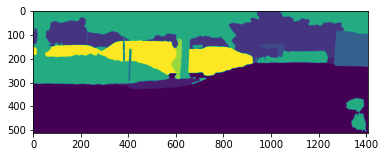

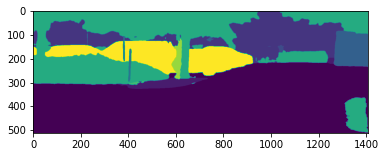

0.9049590229988098

In [51]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

it = iter(test_dataloader)
first = next(it)
second = next(it)

plt.imshow(first['label'][0])
plt.show()
plt.imshow(second['label'][0])
plt.show()

dice_similarity(first['label'], second['label'])    
#dice_similarity(labels, labels)
#labels.shape

In [10]:
model = torch.load('test_new_fusion_10k.pth')
model.eval()
model.cpu()

ResNetUNet_updated(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [12]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


Classes = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
          'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
          'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
          'bicycle']



Color_maps =   {'road': [128, 64, 128],
                'sidewalk' : [244, 35, 232],
                'building' : [70, 70, 70],
                'wall' : [102, 102, 156],
                'fence' : [190, 153, 153],
                'pole' : [153, 153, 153],
                'traffic light' : [250, 170, 30],
                'traffic sign' : [220, 220, 0],
                'vegetation' : [107, 142, 35],
                'terrain' : [152, 251, 152],
                'sky' : [70, 130, 180],
                'person' : [220, 20, 60],
                'rider' : [255, 0, 0],
                'car' : [0, 0, 142],
                'truck' : [0, 0, 70],
                'bus' : [0, 60, 100],
                'train' : [0, 80, 100],
                'motorcycle' : [0, 0, 230],
                'bicycle' : [119, 11, 32] }

legend_elements = []

for i in Classes:
    legend_elements.append(Patch(facecolor=np.asarray(Color_maps[i])/255, edgecolor='r',label=i))
    
def visualize_predictions(sem_pred):
    
    viz_array=np.zeros((sem_pred.shape[0],sem_pred.shape[1],3))
    
    for i in range(sem_pred.shape[0]):
        for j in range(sem_pred.shape[1]):
            viz_array[i,j,:]= np.asarray(Color_maps[Classes[sem_pred[i,j]]])/255
            
    return viz_array

In [52]:
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)


In [15]:
model.cpu()

ResNetUNet_updated(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
test_image = next(iter(test_dataloader))
print(test_image['name'])
image_name = test_image['name'][0].split('/')[-1].replace('xl_signal','xl_visual').replace('xsg','vis')
visual_image = '/home/adarsh/Documents/Dataset/testdataset_01/AI_Data/VisualImages/'+image_name


#visualize on visual image

pred = model(test_image['image'].float().cpu(),test_image['depth'].float().cpu())
plt.figure(figsize= (40,80))

[c2,m2] = xw.XW_ReadFile(visual_image)

#plt.imshow(c2['data'][:,256:1280])
#plt.imshow(test_image['label'][0])
plt.imshow(visualize_predictions(torch.argmax(pred[0],0)),cmap='jet',  alpha = 0.5)#.shape

In [ ]:
plt.figure(figsize= (40,80))
plt.imshow(c2['data'][:,256:1280])
reshape = cv2.resize(visualize_predictions(torch.argmax(pred[0],0)), (1024,512), interpolation = cv2.INTER_NEAREST)
plt.imshow(reshape,cmap='jet',  alpha = 0.5)

In [26]:
[c2,m2] = xw.XW_ReadFile(visual_image)

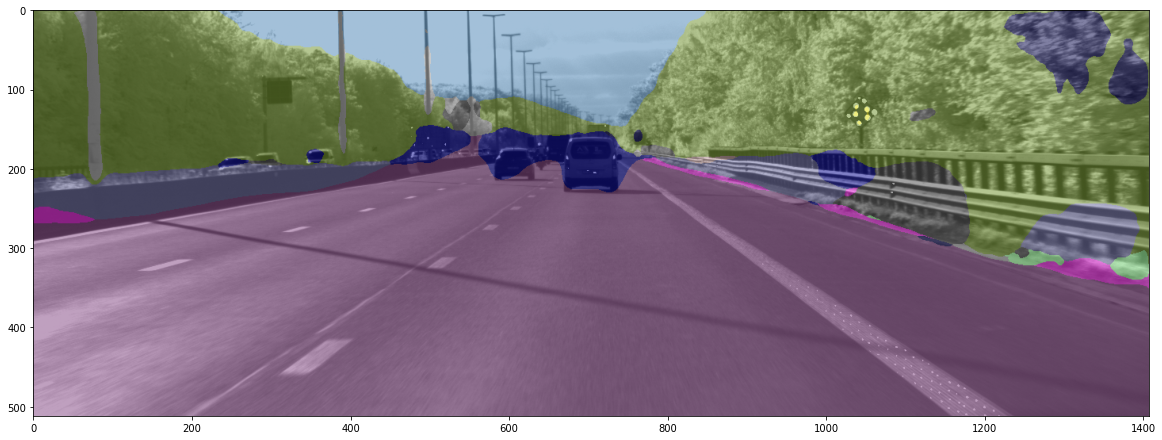

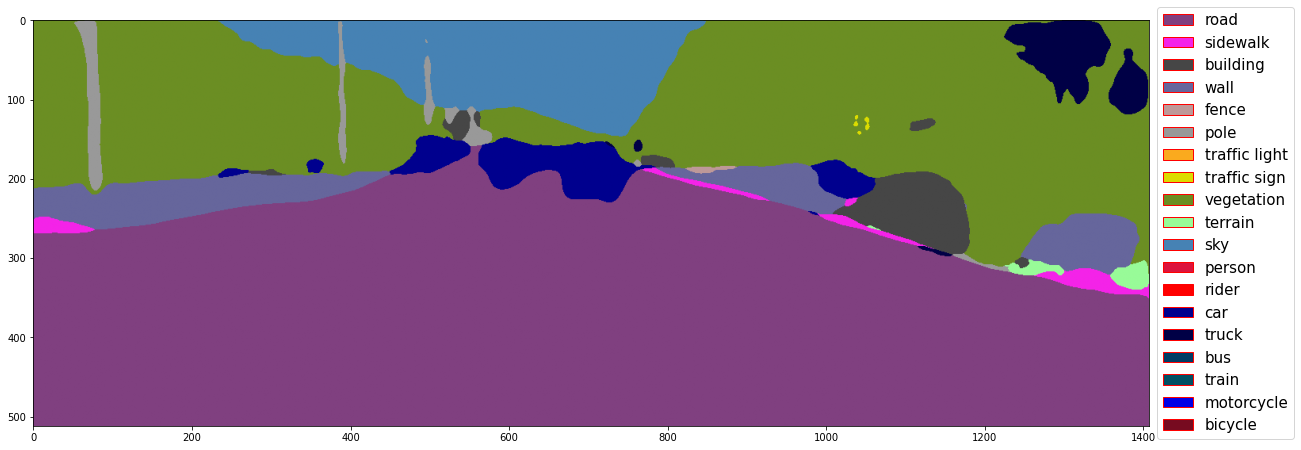

In [126]:
# Final Visualizations

final_pred = torch.argmax(pred[0],0).numpy()

plt.figure(figsize=(20,40))
plt.imshow(cv2.imread(visual_image)[:,128:])
plt.imshow(visualize_predictions(final_pred), alpha=0.5)
plt.show()


fig, ax = plt.subplots(figsize=(20,40))

ax.legend(handles=legend_elements, fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))



plt.imshow(visualize_predictions(final_pred))

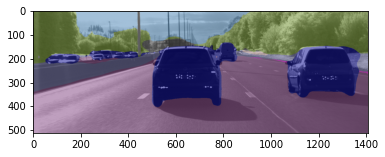

In [84]:
plt.imshow(cv2.imread(visual_image)[:,128:])

plt.imshow(visualize_predictions(final_pred), alpha=0.5)

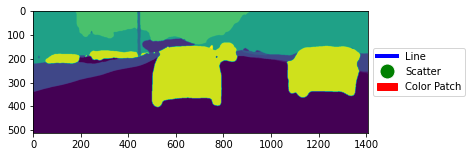

In [71]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor=np.asarray([255, 0, 0])/255, edgecolor='r',
                         label='Color Patch')]



fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.imshow(final_pred)

plt.show()


In [85]:
type(legend_elements)

list

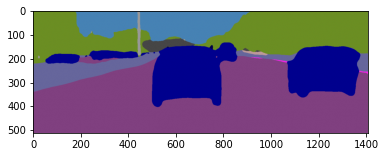

In [82]:
plt.imshow(visualize_predictions(final_pred))

In [133]:
torch.add(torch.randn(1,64,128,384), torch.randn(1,128,384)).shape

torch.Size([1, 64, 128, 384])